# SVD

## Import libraries

In [1]:
from lib.models import RecommendSystemModel

from typing import List, Any, Tuple,Union
from numpy.typing import NDArray
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# import tensorflow as tf
np.random.seed(3362)

## Function to update class in Jupyter Notebook 
https://stackoverflow.com/questions/45161393/jupyter-split-classes-in-multiple-cells

In [2]:
import functools
def update_class(
    main_class=None, exclude=("__module__", "__name__", "__dict__", "__weakref__")
):
    """Class decorator. Adds all methods and members from the wrapped class to main_class

    Args:
    - main_class: class to which to append members. Defaults to the class with the same name as the wrapped class
    - exclude: black-list of members which should not be copied
    """

    def decorates(main_class, exclude, appended_class):
        if main_class is None:
            main_class = globals()[appended_class.__name__]
        for k, v in appended_class.__dict__.items():
            if k not in exclude:
                setattr(main_class, k, v)
        return main_class

    return functools.partial(decorates, main_class, exclude)

### Example

In [3]:
class MyClass:
    def method1(self):
        print("method1")
me = MyClass()


In [4]:
@update_class()
class MyClass:
    def method2(self):
        print("method2")
me.method1()
me.method2()

method1
method2


## The ML model

In [5]:
class SVDModel(RecommendSystemModel):
    def __init__(
        self,
        mode: str = None,
        features: int = None,
        lr: float = None,
        epochs: int = None,
        weight_decay: float = None,
        stopping: float = None,
        momentum: float = None,
    ) -> None:
        super().__init__()
        # Data frame
        self.data: pd.DataFrame
        # # Training data
        self.train: NDArray
        # # Validating Data
        self.valid: NDArray
        self.test: NDArray
        # SVD mode
        self.mode: str = mode or "funk"
        # Number of features
        self.features: int = features or 5
        # Learning rate
        self.lr: float = lr or 0.01
        # Number of total epochs
        self.epochs: int = epochs or 101
        # the weight decay
        self.weight_decay: float = weight_decay or 0.02
        self.stopping: float = stopping or 0.001
        self.momentum: float = momentum or 0.0
        # Tensor SGD optimizer
        # self.optimizer = tf.keras.optimizers.SGD(learning_rate=self.lr, momentum=self.momentum,)

        # # Rating matrix
        # self.R: NDArray
        # # User matrix
        # self.P: NDArray
        # # Item matrix
        # self.Q: NDArray

        # Rating matrix
        # self._R = self.R.copy()
        # User latent matrix
        self._P: NDArray  # = np.random.rand(self.n_users, features) * 0.1
        # Item latent matrix
        self._Q: NDArray  # = np.random.rand(self.n_items, features) * 0.1



In [6]:
@update_class()
class SVDModel(RecommendSystemModel):
    def split(self, ratio_train_test: float, ratio_train_valid: float, tensor: bool = False) -> List[NDArray]:
        userItemMatrix = self.convertToUserItemMatrix(self.data, self.n_users, self.n_items)
        
        trainBeforeSplit = np.zeros((len(userItemMatrix), len(userItemMatrix[0]))).tolist()
        self.train = np.zeros((len(userItemMatrix), len(userItemMatrix[0]))).tolist()
        self.valid = np.zeros((len(userItemMatrix), len(userItemMatrix[0]))).tolist()
        self.test = np.zeros((len(userItemMatrix), len(userItemMatrix[0]))).tolist()

        for i in range(len(userItemMatrix)):
            for j in range(len(userItemMatrix[i])):
                if userItemMatrix[i][j]:
                    if np.random.binomial(1, ratio_train_test, 1):
                        trainBeforeSplit[i][j] = userItemMatrix[i][j]
                    else:
                        self.test[i][j] = userItemMatrix[i][j]
        
        for i in range(len(trainBeforeSplit)):
            for j in range(len(trainBeforeSplit[i])):
                if trainBeforeSplit[i][j]:
                    if np.random.binomial(1, ratio_train_valid, 1):
                        self.train[i][j] = trainBeforeSplit[i][j]
                    else:
                        self.valid[i][j] = trainBeforeSplit[i][j]


In [7]:
@update_class()
class SVDModel(RecommendSystemModel):
    def data_loader(self, path:str=None, nrows:int=None, skiprows=None, data:pd.DataFrame=None, n_users: int = None, n_items = None) -> None:
        if not path and data.empty:
            raise 'Error: one of path or data frame should be provided'
        if data.empty:
            self.data = pd.read_csv(path,low_memory=False,nrows=nrows,skiprows=skiprows)
        elif not path:
            self.data = data
        self.n_users = n_users
        self.n_items = n_items

In [8]:
@update_class()
class SVDModel(RecommendSystemModel):
    def training(self) -> Tuple[NDArray, NDArray, float, float]:
        loss_train = []
        loss_valid = []
        errors = []

        # self.n_users = len(self.train)
        # self.n_items = len(self.valid)
        self._P = np.random.rand(self.n_users, self.features) * 0.1
        self._Q = np.random.rand(self.n_items, self.features) * 0.1
        # print(np.shape(self._P))
        # print(np.shape(self._Q))
        
        self._bu = np.zeros(self.n_users)
        self._bi = np.zeros(self.n_items)
        self.mean = 0 # TODO calculate the mean of rating

        # Johnny
        for e in range(self.epochs):
            for id_user in range(self.n_users):
                for id_item in range(self.n_items):
                    if self.train[id_user][id_item] > 0:
                        
                        predict = self.prediction(id_user, id_item)
                        
                        error = self.train[id_user][id_item] - predict
                        errors.append(error)
                        
                        self.optimize(error, id_user, id_item)
            trainLoss = self.loss(self.train)
            validLoss = self.loss(self.valid)
            loss_train.append(trainLoss)
            loss_valid.append(validLoss)
            if e % 10 == 0:
                print('Epoch : ', "{:3.0f}".format(e+1), ' | Train :', "{:3.3f}".format(trainLoss), 
                    ' | Valid :', "{:3.3f}".format(validLoss))
                
            if e > 1:
                if abs(validLoss - trainLoss) < self.stopping:
                    print('Training stopped:')
                    print('Epoch : ', "{:3.0f}".format(e+1), ' | Train :', "{:3.3f}".format(trainLoss), 
                    ' | Valid :', "{:3.3f}".format(validLoss))
                    break
        return loss_train, loss_valid, errors

In [9]:
@update_class()
class SVDModel(RecommendSystemModel):
    def convertToUserItemMatrix(self, data, n_users, n_movies):
        # data = np.array(data,dtype=int)
        # userItemMatrix = []
        # for id_user in range(1, n_users + 1):
        #     if id_user % 1000 == 0: print('{}/{}'.format(id_user, n_users))
        #     # id_movies = np.array([ratingRecord[1] for ratingRecord in data if ratingRecord[0] == id_user],dtype=int)
        #     # # print(id_movies.dtype)
        #     # id_ratings = [ratingRecord[2] for ratingRecord in data if ratingRecord[0] == id_user]
        #     _data = data[:, 0]
        #     id_movies = data[:, 1][_data == id_user]
        #     id_ratings = data[:, 2][_data == id_user]
        #     ratings = np.zeros(n_movies)
        #     ratings[id_movies - 1] = id_ratings
        #     # try:
        #     #     ratings[id_movies - 1] = id_ratings
        #     # except:
        #     #     print(id_user)
        #     #     raise 'Error:'
        #     userItemMatrix.append(list(ratings))
        userItemMatrix = np.zeros((n_users, n_movies))
        for id_user in range(1, n_users + 1):
            id_movies = data[:, 1][data[:, 0] == id_user]
            id_ratings = data[:, 2][data[:, 0] == id_user]
            userItemMatrix[id_user-1,id_movies - 1] = id_ratings
        
        return userItemMatrix

In [10]:
@update_class()
class SVDModel(RecommendSystemModel):
    def prediction(self, u: int, i: int) -> float:
        # Woody
        # print(P[u: ])
        predict = np.dot(self._P[u, : ], self._Q[i, : ])
        if self.mode == 'svd++':
            predict += self._mean + self._bu[u] + self._bi[i]
        return predict

In [11]:
@update_class()
class SVDModel(RecommendSystemModel):
    def loss(self, groundTruthData:NDArray) -> float:
        # Woody
        squaredErrors = 0.0
        numOfPrediction = 0
        # nb_users, nb_items = len(data), len(data[0])
        
        for u in range(self.n_users):
            for i in range(self.n_items):
                if groundTruthData[u][i] > 0:
                    squaredErrors += pow(groundTruthData[u][i] - self.prediction(u, i), 2)
                    numOfPrediction += 1
        return squaredErrors / numOfPrediction

In [12]:
@update_class()
class SVDModel(RecommendSystemModel):
    def optimize(self, error:float, id_user:int, id_item:int):
        # Johnny
        # P[id_user] = self.optimizer.minimize(P[id_user], [error])
        # Q[id_item] = self.optimizer.minimize()
        # return super().svd()

        # self._P[id_user, :] += self.lr * (error * self._Q[id_item,:] - self.weight_decay * self._P[id_user,:])
        # self._Q[id_item, :] += self.lr * (error * self._P[id_user,:] - self.weight_decay * self._Q[id_item,:])

        for feature in range(self.features):
            self._P[id_user, feature] = self.lr * (self._Q[id_item, feature] * error - self.weight_decay*self._P[id_user, feature]) + self._P[id_user, feature]
            self._Q[id_item, feature] = self.lr * (self._P[id_user, feature] * error - self.weight_decay*self._Q[id_item, feature]) + self._Q[id_item, feature]

In [13]:
# define the paths
data_path = './data/ml-latest-small/'
df_rating = pd.read_csv(data_path+'ratings.csv')
df_movies = pd.read_csv(data_path+'movies.csv')
m_movies = df_movies['movieId'].nunique()
n_users = df_rating['userId'].nunique()
n_ratings = len(df_rating)

In [14]:
print(m_movies)
print(n_users)
print(df_rating)
print(df_movies)

9742
610
        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]
      movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  B

In [15]:
df_movies['movieId'].max()

193609

In [16]:
df_rating['userId'].max()

610

In [17]:
df_movies.insert(1, 'newMovieId', value=range(1,len(df_movies)+1))

In [18]:
newMovieIdDict = {}
for index, movie in df_movies.iterrows():
  newMovieIdDict[movie['movieId']] = movie['newMovieId']

In [19]:
newMovieIdDict[193583]

9739

In [20]:
df_rating.replace({"movieId": newMovieIdDict}, inplace=True)

In [21]:
# for index, rating in df_rating.iterrows():
#   if index % 100000 == 0: print('{}/{}'.format(index, len(df_rating)))
#   rating['movieId'] = newMovieIdDict[rating['movieId']]

In [22]:
# for index, movie in df_movies.iterrows():
#   for index, rating in df_rating.iterrows():
#     if rating['movieId'] == movie['movieId']:
#       rating['movieId'] = index+1

In [23]:
# for index, movie in df_movies.iterrows():
#   c = df_rating['movieId'].eq(movie['movieId'])
#   df_rating.loc[c,'movieId']=index+1

In [24]:
# data = np.array(df_rating,dtype=int)
# u3 = data[:, 1][data[:, 0] == 3]
# print(len(u3))
# print(u3)

In [25]:

df_rating['rating'] = df_rating['rating'].astype(np.int64)
df_rating.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   userId     100836 non-null  int64
 1   movieId    100836 non-null  int64
 2   rating     100836 non-null  int64
 3   timestamp  100836 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [26]:
df_rating.empty

False

In [27]:
features = 5
lr = 0.01
epochs = 101
weight_decay = 0.02
stopping = 0.001

svd = SVDModel(features=features, lr=lr, epochs=epochs, weight_decay=weight_decay, stopping=stopping)

In [28]:
svd.data_loader(data=df_rating, n_items = m_movies, n_users=n_users)

In [29]:
print(svd.n_items)
print(svd.__dict__)
# svd.n_items = 10

9742
{'mode': 'funk', 'features': 5, 'lr': 0.01, 'epochs': 101, 'weight_decay': 0.02, 'stopping': 0.001, 'momentum': 0.0, 'data':         userId  movieId  rating   timestamp
0            1        1       4   964982703
1            1        3       4   964981247
2            1        6       4   964982224
3            1       44       5   964983815
4            1       47       5   964982931
...        ...      ...     ...         ...
100831     610     9435       4  1493848402
100832     610     9462       5  1493850091
100833     610     9463       5  1494273047
100834     610     9464       5  1493846352
100835     610     9504       3  1493846415

[100836 rows x 4 columns], 'n_users': 610, 'n_items': 9742}


In [30]:
svd.split(0.6,0.8)

In [31]:
print(len(svd.test), len(svd.test[0]))

610 9742


In [32]:

loss_train, loss_valid, errors = svd.training()

'''
Epoch :    1  | Train : 6.678  | Valid : 6.955
Epoch :   11  | Train : 0.712  | Valid : 1.397
'''

Epoch :    1  | Train : 6.678  | Valid : 6.955
Epoch :   11  | Train : 0.712  | Valid : 1.397


KeyboardInterrupt: 

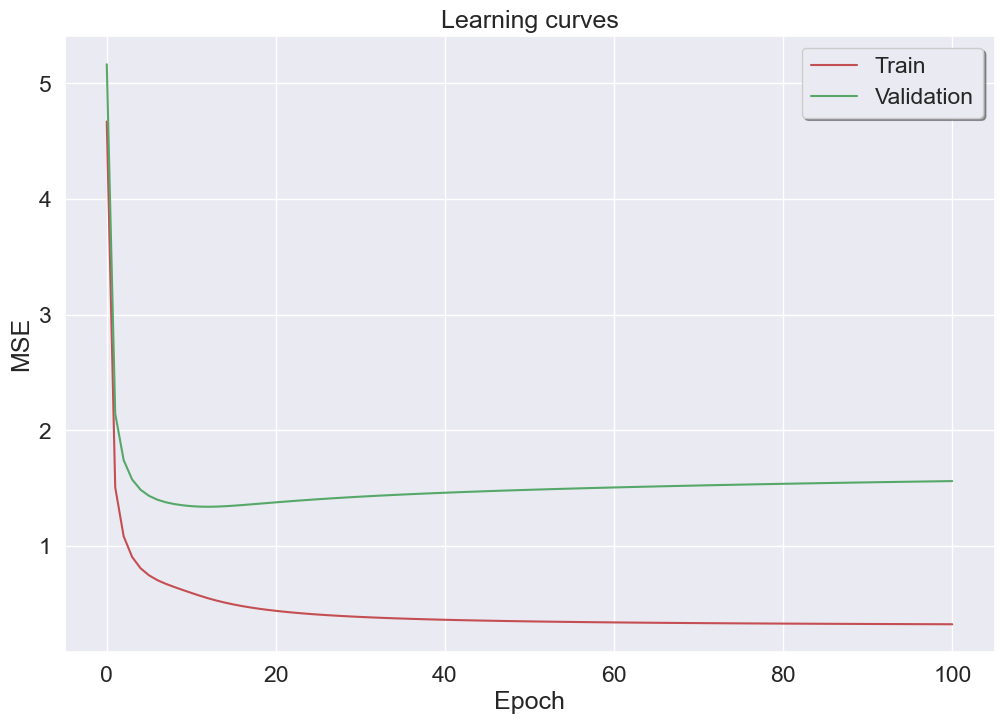

In [ ]:
x = list(range(len(loss_train)))
k=0

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.plot(x[-k:], loss_train[-k:], 'r', label="Train")
plt.plot(x[-k:], loss_valid[-k:], 'g', label="Validation")
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
leg = plt.legend(loc='best', shadow=True, fancybox=True)